In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '/data2/cosmo4d/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]

In [3]:
suff = '-pad4'
num_cubes= 1000
cube_size = 32
pad = 4
cube_sizeft = cube_size + 2*pad
max_offset = ncp - cube_size
ftname = ['cic']
nchannels = len(ftname)

In [4]:
#############################
##Read data and generate meshes
#mesh = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/d/')
meshes = {}
cube_features, cube_target = [], []
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    hposd = hposall[:num].copy()
    hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['pnn']
    features, target = dtools.randomvoxels(ftlistpad, targetmesh, num_cubes, max_offset, cube_size, cube_sizeft)
    cube_features = cube_features + features
    cube_target = cube_target + target

#
cube_target = np.stack(cube_target,axis=0).reshape((-1,cube_size,cube_size,cube_size,1))
print(cube_target.sum(), cube_target.size, targetmesh.sum())
print(len(cube_features))
print(cube_features[0].shape)
cube_features = np.stack(cube_features,axis=0).reshape((-1,cube_sizeft,cube_sizeft,cube_sizeft,nchannels))
trainingsize = cube_features.shape[0]
print('Training size is = ', trainingsize)


All the mesh have been generated for seed = 100
All the mesh have been generated for seed = 200
All the mesh have been generated for seed = 300
All the mesh have been generated for seed = 400
4004974.0 131072000 64000.0
4000
(40, 40, 40, 1)
Training size is =  4000


Text(0.5, 1.0, 'Target')

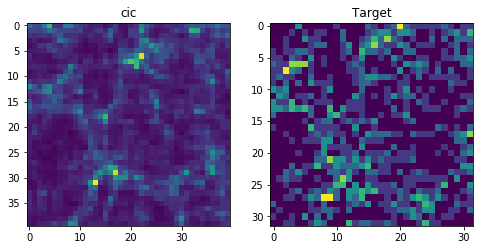

In [5]:
fig, ax = plt.subplots(1, nchannels+1, figsize = (nchannels*4+4, 5))
n = 10
for i in range(nchannels):
    ax[i].imshow(cube_features[n][:,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
ax[-1].imshow(cube_target[n][:,:,:,0].sum(axis=0))
ax[-1].set_title('Target')

In [8]:
# Define the network
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
y = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
lr = tf.placeholder(tf.float32, name='learningrate')

net = slim.conv3d(x, 16, 5, activation_fn=tf.nn.leaky_relu, padding='valid')
net = slim.conv3d(net, 32, 5, activation_fn=None, padding='valid')
net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
net = slim.conv3d(net, 1, 3, activation_fn=None)
pred = tf.nn.sigmoid(net, name='prediction')

loss = tf.losses.sigmoid_cross_entropy(y, net)
optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='optimizer')

opt_op = optimizer.minimize(loss, name='minimize')

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = []

niter= 100000
nprint = 100
batch_size=32
#
start = time()
curr = time()
lr0, nlr = 0.001, int(5000)
for it in range(niter):
    inds = np.random.choice(int(trainingsize), batch_size, replace=False)
    _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, x:cube_features[inds], y:clip(cube_target[inds],0,1)})
    if it % nlr == nlr-1:
        lr0 /= 10
        print('reduce learning rate by half. New learning rate = %0.2e'%lr0)        
    if it % nprint == 0:
        print('Iteration %d of %d'%(it, niter), '\nLoss = ', l)
        end = time()
        print('Time taken for last batch = %0.3f, Total time elapsed = %0.3f'%(end-curr, end - start))
        curr = end
    losses.append(l)


Iteration 0 of 100000 
Loss =  0.9042912
Time taken for last batch = 1.833, Total time elapsed = 1.833
Iteration 100 of 100000 
Loss =  0.06435697
Time taken for last batch = 59.980, Total time elapsed = 61.813
Iteration 200 of 100000 
Loss =  0.06252686
Time taken for last batch = 61.233, Total time elapsed = 123.047
Iteration 300 of 100000 
Loss =  0.061727114
Time taken for last batch = 61.419, Total time elapsed = 184.466
Iteration 400 of 100000 
Loss =  0.05684154
Time taken for last batch = 61.474, Total time elapsed = 245.940
Iteration 500 of 100000 
Loss =  0.055095136
Time taken for last batch = 61.419, Total time elapsed = 307.359
Iteration 600 of 100000 
Loss =  0.05466295
Time taken for last batch = 61.458, Total time elapsed = 368.817
Iteration 700 of 100000 
Loss =  0.050289806
Time taken for last batch = 61.441, Total time elapsed = 430.258
Iteration 800 of 100000 
Loss =  0.04486132
Time taken for last batch = 61.438, Total time elapsed = 491.696
Iteration 900 of 100000

KeyboardInterrupt: 

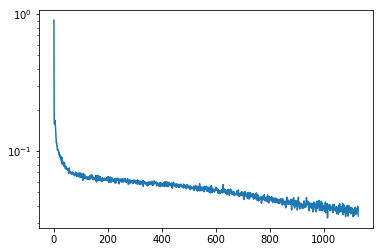

In [10]:
plot(losses)
yscale('log')

In [48]:
# some more training
lr0 = 0.0005
niter=2000
for it in range(niter):
    inds = np.random.choice(int(trainingsize), batch_size, replace=False)
    _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, x:cube_features[inds], y:clip(cube_target[inds],0,1)}) 
    if it % nprint == 0:
        print('Iteration %d of %d'%(it, niter), '\nLoss = ', l)
        end = time()
        print('Time taken for last batch = %0.3f, Total time elapsed = %0.3f'%(end-curr, end - start))
        curr = end
    losses.append(l)


Iteration 0 of 2000 
Loss =  0.03364487
Time taken for last batch = 54.827, Total time elapsed = 1541.822
Iteration 100 of 2000 
Loss =  0.03050107
Time taken for last batch = 62.623, Total time elapsed = 1604.445
Iteration 200 of 2000 
Loss =  0.030628664
Time taken for last batch = 62.688, Total time elapsed = 1667.134


KeyboardInterrupt: 

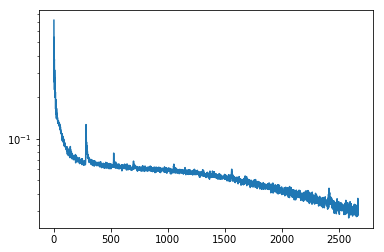

In [60]:
plot(losses)
yscale('log')

Text(0.5, 1.0, 'features')

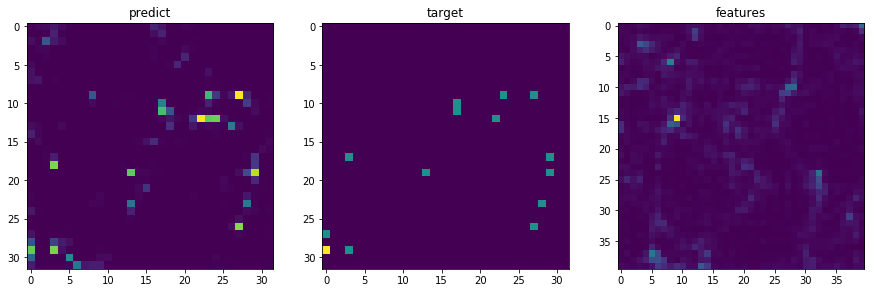

In [11]:
ind = 0
input = cube_features[ind]
recp = sess.run(pred, feed_dict={x:input.reshape(1, *input.shape)})

fig, ax = plt.subplots(1, 3, figsize=(15,7))
ax[0].imshow(recp[ind,0,:,:,0]);
ax[0].set_title('predict')
ax[1].imshow(cube_target[ind,0,:,:,0]);
ax[1].set_title('target')
ax[2].imshow(cube_features[ind,0,:,:,0]);
ax[2].set_title('features')

In [12]:
input = x
prediction = pred
#############################
meshes = {}
cube_features, cube_target = [], []
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    hposd = hposall[:num].copy()
    hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['target'] = hmesh['pnn'].copy()
    
    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['target']

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube)
    recp = sess.run(prediction, feed_dict={input:inp})
    mesh['predict'] = dtools.uncubify(recp[:,:,:,:,0], [nc,nc,nc])
    
    meshes[seed] = [mesh, hmesh]


All the mesh have been generated for seed = 100
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 200
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 300
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 400
(32, 32, 32) [128 128 128]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Predict')

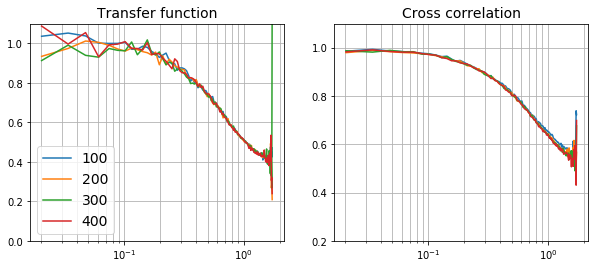

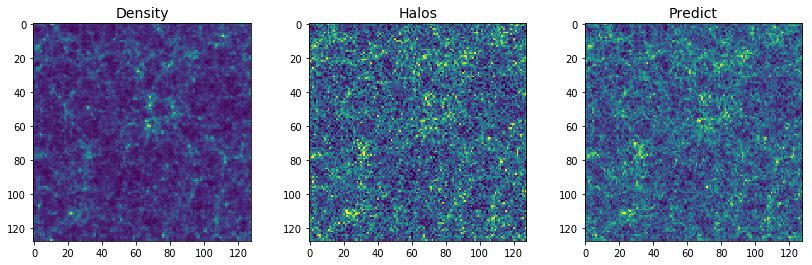

In [13]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5


fig, ax = plt.subplots(1, 2, figsize = (10, 4))
for seed in seeds:
    predict, hpmeshd = meshes[seed][0]['predict'], clip(meshes[seed][1]['target'],0,1), 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)
    #k, pkpredall = tools.power(predictall/predictall.mean(), boxsize=bs, k=kmesh)
    #k, pkhallx = tools.power(hpmeshd/hpmeshd.mean(), predictall/predictall.mean(), boxsize=bs, k=kmesh)
    
    ##
    ax[0].semilogx(k, pkpred/pkhd, label=seed)
    ax[1].semilogx(k, pkhx/(pkpred*pkhd)**0.5)
    # plt.plot(k, pkpredall/pkhd)
    
ax[0].legend(fontsize=14)
ax[0].grid(which='both')
ax[1].grid(which='both')
ax[0].set_title('Transfer function', fontsize=14)
ax[1].set_title('Cross correlation', fontsize=14)
#plt.savefig('./figs/n%02d/2ptpredict%s.png'%(numd*1e4, suff))
ax[0].set_ylim(0.,1.1)
ax[1].set_ylim(0.2,1.1)

fig, ax = plt.subplots(1, 3, figsize = (14, 4))
ax[0].imshow(meshes[seed][0]['cic'].sum(axis=0))
ax[0].set_title('Density', fontsize=14)
ax[1].imshow(meshes[seed][1]['target'].sum(axis=0),vmin=0,vmax=12)
ax[1].set_title('Halos', fontsize=14)
ax[2].imshow(meshes[seed][0]['predict'].sum(axis=0),vmin=0,vmax=12)
ax[2].set_title('Predict', fontsize=14)
#plt.savefig('./figs/n%02d/impredict%s.png'%(numd*1e4, suff))



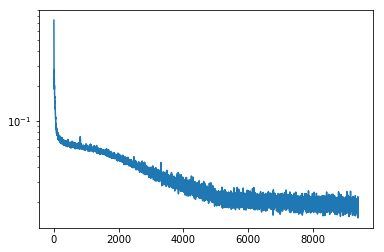

In [32]:
# Some previous results
plot(losses)
yscale('log')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Predict')

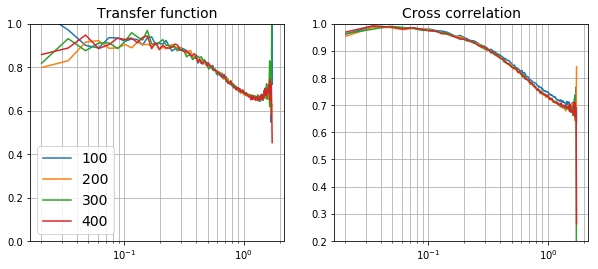

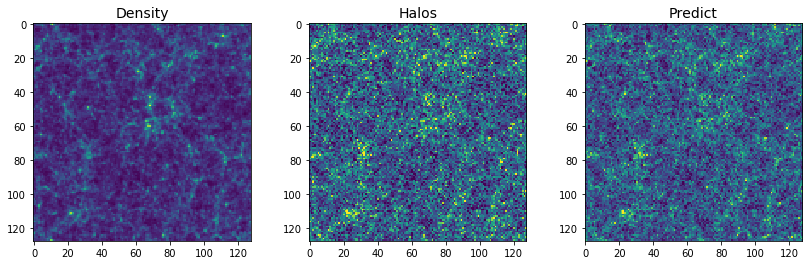

In [30]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5


fig, ax = plt.subplots(1, 2, figsize = (10, 4))
for seed in seeds:
    predict, hpmeshd = meshes[seed][0]['predict'], meshes[seed][1]['target'], 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)
    #k, pkpredall = tools.power(predictall/predictall.mean(), boxsize=bs, k=kmesh)
    #k, pkhallx = tools.power(hpmeshd/hpmeshd.mean(), predictall/predictall.mean(), boxsize=bs, k=kmesh)
    
    ##
    ax[0].semilogx(k, pkpred/pkhd, label=seed)
    ax[1].semilogx(k, pkhx/(pkpred*pkhd)**0.5)
    # plt.plot(k, pkpredall/pkhd)
    
ax[0].legend(fontsize=14)
ax[0].grid(which='both')
ax[1].grid(which='both')
ax[0].set_title('Transfer function', fontsize=14)
ax[1].set_title('Cross correlation', fontsize=14)
#plt.savefig('./figs/n%02d/2ptpredict%s.png'%(numd*1e4, suff))
ax[0].set_ylim(0.,1)
ax[1].set_ylim(0.2,1)

fig, ax = plt.subplots(1, 3, figsize = (14, 4))
ax[0].imshow(meshes[seed][0]['cic'].sum(axis=0))
ax[0].set_title('Density', fontsize=14)
ax[1].imshow(meshes[seed][1]['target'].sum(axis=0),vmin=0,vmax=12)
ax[1].set_title('Halos', fontsize=14)
ax[2].imshow(meshes[seed][0]['predict'].sum(axis=0),vmin=0,vmax=12)
ax[2].set_title('Predict', fontsize=14)
#plt.savefig('./figs/n%02d/impredict%s.png'%(numd*1e4, suff))

